# Food Scanner 2019 - Database n°2

**Dataset**: https://gitlab.com/our-sci/rfc-docs/-/blob/master/2019/dataset/completeDatasetAllVariables.csv - (4150, 1494)

In [1]:
import warnings
from sys import stdout

import numpy as np
import pandas as pd
import pylab as plot
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from IPython.display import display

from module_utils.utils import head_shape, describe_plus, na_per_col, total_na_df, heatmap_isna,\
                               dist_quantitative_features, dist_of_target_per_type, compare_plot_mean_std,\
                               plot_boxplot_outliers, violin_quantitative_features, highlight_bests_metrics,\
                               train_test_df
from module_utils.preprocess import array_to_df, msc, snv, savgol_smoothing, norml, extract_and_transform, onehot_encoder
from module_utils.model_training import training_models, compute_losses_reg, train_model, compute_train_test_metrics, plot_predicted

sns.set(font_scale=1.2, style="darkgrid", palette="colorblind", color_codes=True)
pd.options.display.float_format = '{:.5f}'.format
params = {"legend.fontsize":15, "legend.handlelength":2}
# plot.rcParams.update(params)
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('dataset/completeDatasetAllVariables.csv', sep = ',')

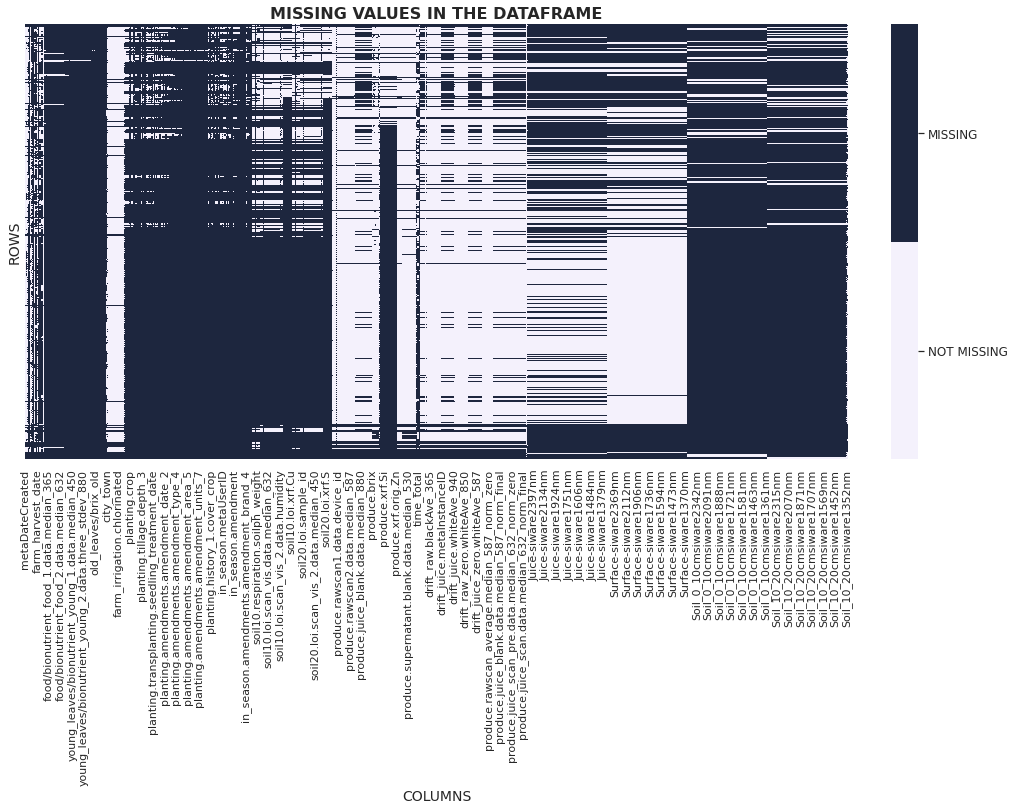

In [3]:
heatmap_isna(df)

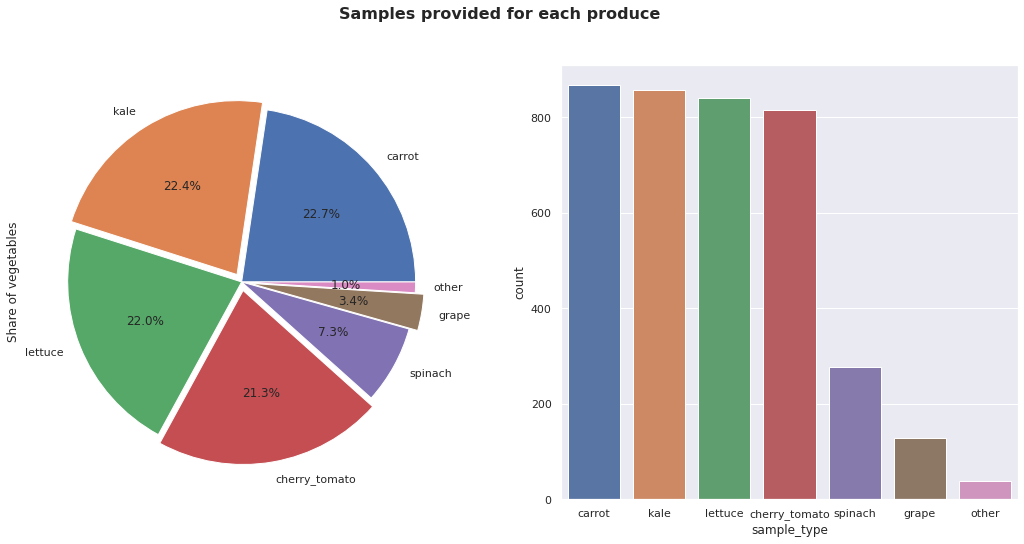

In [4]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
f.suptitle("Samples provided for each produce", fontsize=16, weight="bold")
df['sample_type'].value_counts().plot.pie(explode=[0,0.05,0,0.05,0,0.05,0], autopct='%1.1f%%', ax=ax[0])
ax[0].set_ylabel('Share of vegetables')
sns.countplot(x="sample_type", data=df, ax=ax[1], order=df['sample_type'].value_counts().index)
plt.show()

## Input variables
### Juice columns

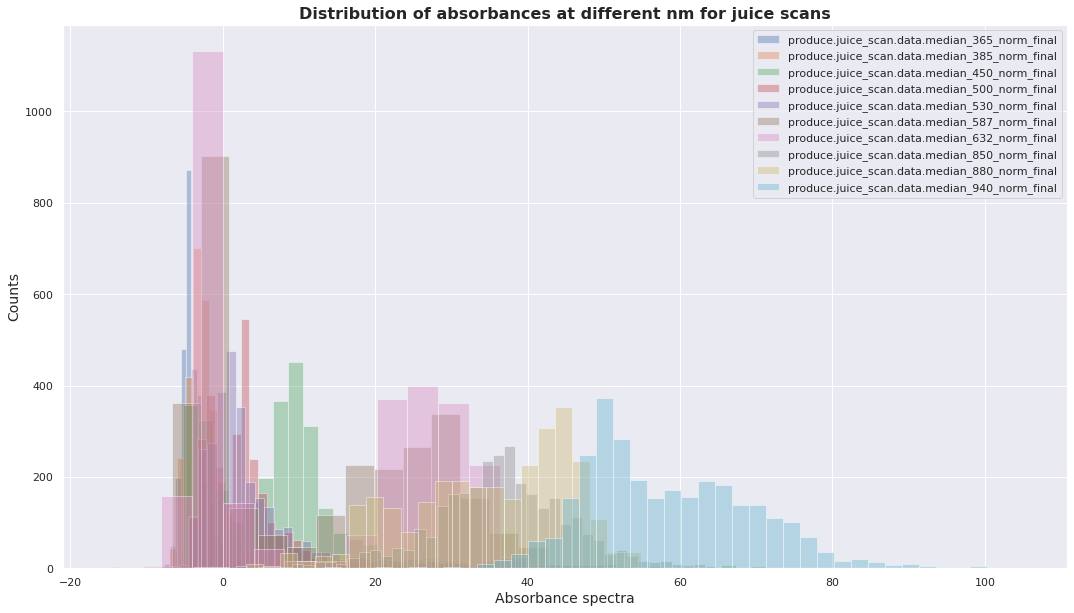

In [5]:
juice_columns = df.filter(regex='juice').columns
juice_scan_final = df.columns.str.startswith('produce.juice_scan.data.median_') & df.columns.str.endswith('_final')
juice_scan_final_cols = df.loc[:, juice_scan_final].columns
dist_quantitative_features(df=df, quant_feat=juice_scan_final_cols,
                          title="Distribution of absorbances at different nm for juice scans",
                          xlabel="Absorbance spectra",
                          ylabel="Counts")

### Raw scan

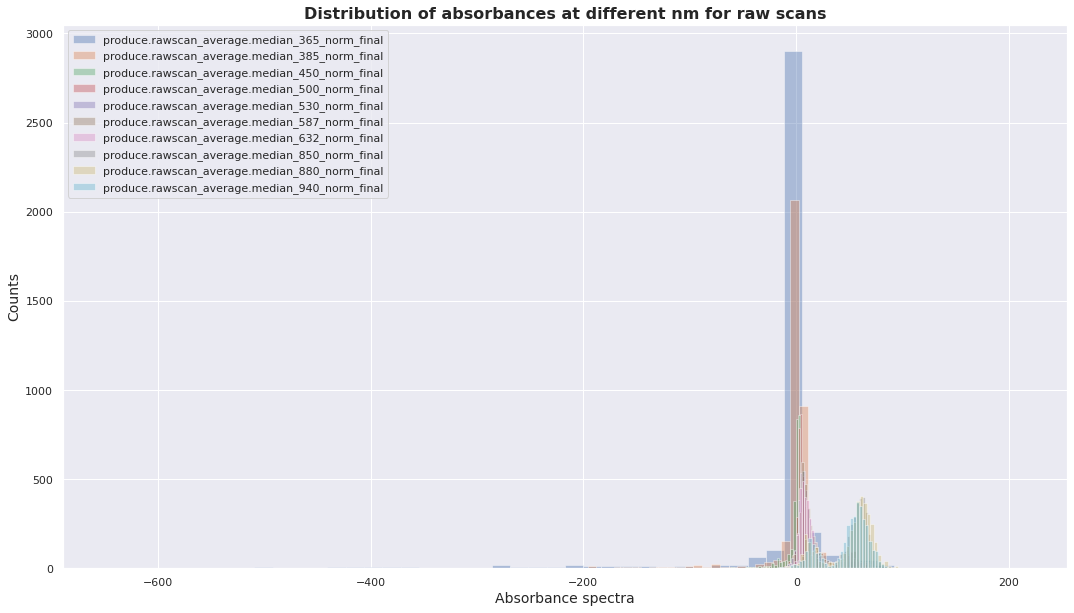

In [6]:
raw_scan_final = df.columns.str.startswith('produce.rawscan_average.median_') & df.columns.str.endswith('_final')
raw_scan_final_cols = df.loc[:, raw_scan_final].columns
dist_quantitative_features(df=df, quant_feat=raw_scan_final_cols,
                          title="Distribution of absorbances at different nm for raw scans",
                          xlabel="Absorbance spectra",
                          ylabel="Counts")

In [7]:
df_raw = df[raw_scan_final_cols].rename(columns=lambda col: str(col[31:34]), inplace=False)
df_juice = df[juice_scan_final_cols].rename(columns=lambda col: str(col[31:34]), inplace=False)
wavelength = df_juice.columns

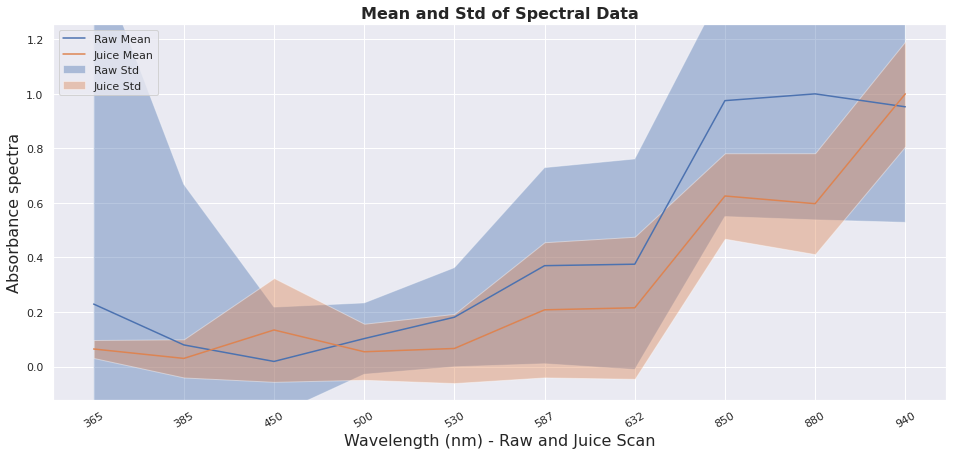

In [8]:
compare_plot_mean_std(df1 = df_raw, df2 = df_juice,
                      xlabel="Wavelength (nm) - Raw and Juice Scan", ylabel="Absorbance spectra", title="Mean and Std of Spectral Data",
                      label_mean="Raw Mean", label_std="Raw Std", label_mean2="Juice Mean", label_std2="Juice Std", figsize=(16,6))

## Target variables

In [9]:
brix_cols = df.filter(regex='produce.brix').columns
polyphenols = df.filter(regex='polyphenols').columns
antioxidants = df.filter(regex='antioxi').columns

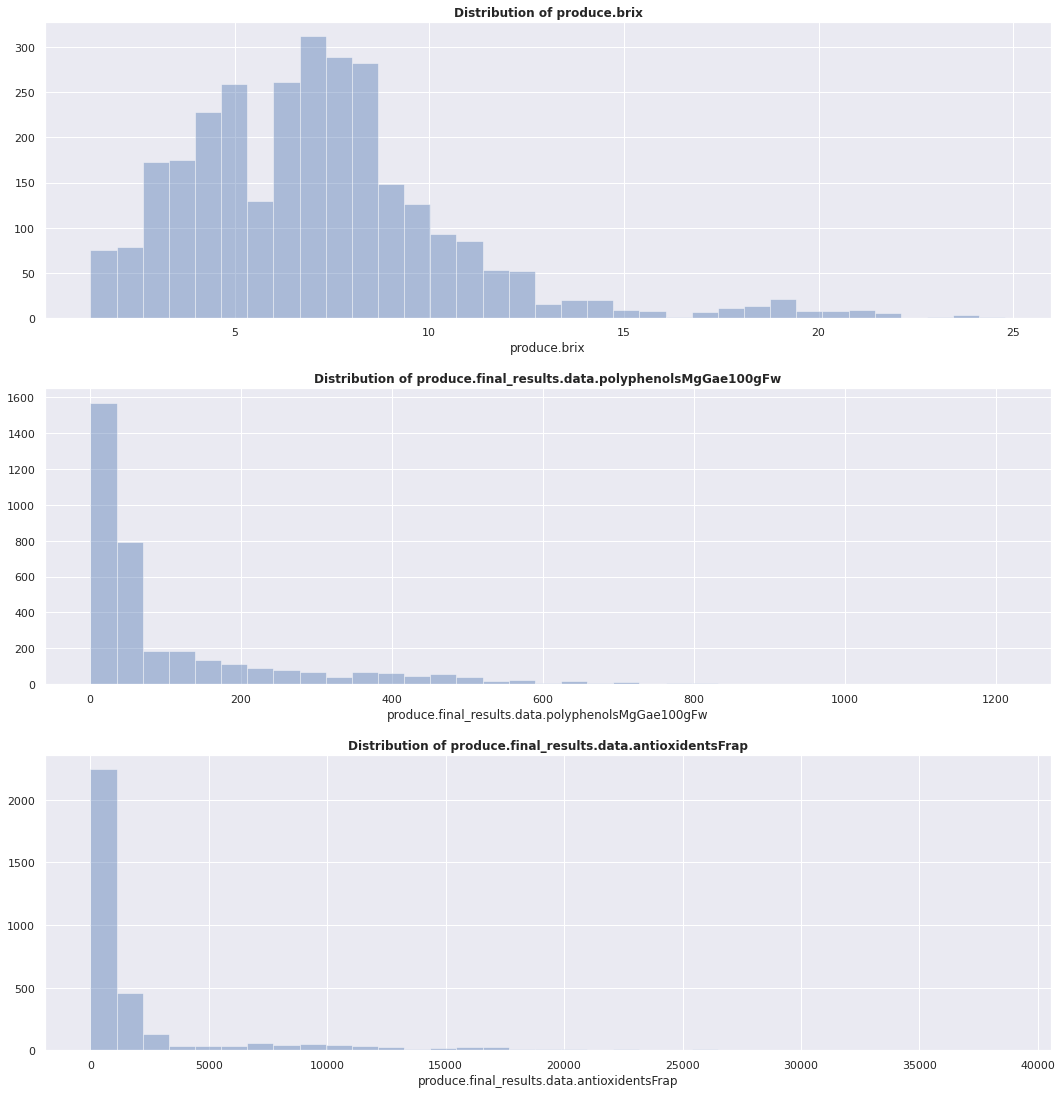

In [10]:
target_variables = ['produce.brix', 'produce.final_results.data.polyphenolsMgGae100gFw', 'produce.final_results.data.antioxidentsFrap']
fig = plt.figure(figsize=(15, 15))
for i, element in enumerate(target_variables):
    fig.tight_layout(pad=1.5)
    ax = fig.add_subplot(3, 1, i+1)
    sns.distplot(df[element].dropna(), hist=True, kde=False, bins=35)
    plt.title("Distribution of {}".format(element), fontweight="bold")

## Modeling

In [11]:
# init model objects
lin_reg = LinearRegression()
ridge_reg = Ridge(alpha=1, solver="cholesky")
svr_rbf = MultiOutputRegressor(SVR(kernel='rbf', C=10, gamma='auto', epsilon=.1, coef0=1))
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=0)
models_list = [lin_reg, ridge_reg, svr_rbf, rf_regressor]
# create list of models used for training - for columns name
models_name = ['Linear regression', 'Ridge regression', 'SVR RBF', 'RF regressor']

In [12]:
df_test = df.filter(regex='sample_type|produce.brix|produce.final_results.data.polyphenolsMgGae100gFw_dry|produce.final_results.data.antioxidentsFrap_dry|rawscan_average.median_365_norm_final|rawscan_average.median_385_norm_final|rawscan_average.median_450_norm_final|rawscan_average.median_500_norm_final|rawscan_average.median_530_norm_final|rawscan_average.median_587_norm_final|rawscan_average.median_632_norm_final|rawscan_average.median_850_norm_final|rawscan_average.median_850_norm_final|rawscan_average.median_880_norm_final|rawscan_average.median_940_norm_final')
df_test.drop(['sample_type_other', 'produce.sample_type', 'produce.sample_type_other'], axis=1, inplace=True)
df_test.rename(columns={"sample_type":"Type","produce.brix":'Brix',"produce.final_results.data.polyphenolsMgGae100gFw_dry":'Polyphenols (mg/100g)',
                       "produce.final_results.data.antioxidentsFrap_dry":'Antioxidant (µmol/100g)'}, inplace=True)

cols = list(df_test.columns.values)
cols.pop(cols.index('Type'))
df_test = df_test[cols+['Type']]

In [13]:
df_type_target_rawscan = df_test.dropna()
index_df = df_type_target_rawscan.index
columns_types = np.sort(df_type_target_rawscan['Type'].unique())
values = np.array(df_type_target_rawscan[['Type']])

In [14]:
df_type = onehot_encoder(values, index_df, columns_types)
df_ohe = pd.concat([df_type_target_rawscan, df_type], axis=1).drop("Type", axis=1)
head_shape(df_ohe)

Brix  Polyphenols (mg/100g)  Antioxidant (µmol/100g)  \
36 6.90000              756.75000             142669.00000   
37 6.90000              756.75000             142669.00000   
39 7.10000               42.30000                561.56000   
43 2.70000              421.30000               5938.19000   
44 2.70000              421.30000               5938.19000   

    produce.rawscan_average.median_365_norm_final  \
36                                     -437.20000   
37                                     -437.20000   
39                                        3.81600   
43                                        0.03183   
44                                        0.03183   

    produce.rawscan_average.median_385_norm_final  \
36                                     -189.30000   
37                                     -189.30000   
39                                        3.57800   
43                                        0.25140   
44                                        0.25140   

    produce.rawscan_average.median_450_norm_final  \
36                                      -46.02000   
37                                      -46.02000   
39                                        1.56200   
43                                        6.26000   
44                                        6.26000   

    produce.rawscan_average.median_500_norm_final  \
36                                       -8.53500   
37                                       -8.53500   
39                                        6.39500   
43                                       10.43000   
44                                       10.43000   

    produce.rawscan_average.median_530_norm_final  \
36                                       -8.50000   
37                                       -8.50000   
39                                       12.91000   
43                                       19.14000   
44                                       19.14000   

    produce.rawscan_average.median_587_norm_final  \
36                                       -2.64400   
37                                       -2.64400   
39                                       61.10000   
43                                       19.41000   
44                                       19.41000   

    produce.rawscan_average.median_632_norm_final  \
36                                        1.31300   
37                                        1.31300   
39                                       55.22000   
43                                       12.44000   
44                                       12.44000   

    produce.rawscan_average.median_850_norm_final  \
36                                       12.80000   
37                                       12.80000   
39                                       69.03000   
43                                       51.86000   
44                                       51.86000   

    produce.rawscan_average.median_880_norm_final  \
36                                       11.59000   
37                                       11.59000   
39                                       86.93000   
43                                       62.45000   
44                                       62.45000   

    produce.rawscan_average.median_940_norm_final  carrot  cherry_tomato  \
36                                       -0.26470       0              1   
37                                       -0.26470       0              1   
39                                       55.88000       1              0   
43                                       45.93000       0              0   
44                                       45.93000       0              0   

    grape  kale  lettuce  other  spinach  
36      0     0        0      0        0  
37      0     0        0      0        0  
39      0     0        0      0        0  
43      0     0        1      0        0  
44      0     0        1      0        0

(2780, 20)

In [15]:
x, y = extract_and_transform(df=df_ohe, index=3, transformer_y=StandardScaler)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [16]:
print('x train set:', x_train.shape)
print('y train set:', y_train.shape)
print('x test set:', x_test.shape)
print('y test set:', y_test.shape)

x train set: (1946, 17)
y train set: (1946, 3)
x test set: (834, 17)
y test set: (834, 3)


In [17]:
df_train, df_test = compute_train_test_metrics(x_train, y_train, x_test, y_test, models_list, models_name)
display(highlight_bests_metrics(df_train))
display(highlight_bests_metrics(df_test))

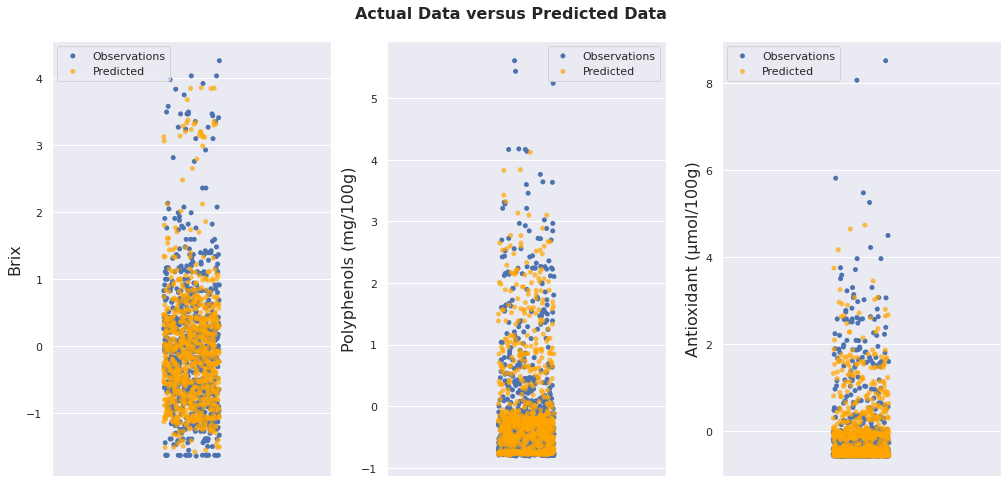

In [18]:
train_model(rf_regressor, x_train, y_train)
y_pred=rf_regressor.predict(x_test)
plot_predicted(y_test, y_pred, ['Brix', 'Polyphenols (mg/100g)', 'Antioxidant (µmol/100g)'],
               title_pred="Actual Data versus Predicted Data")